[CellChat Vignette](https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/CellChat-vignette.html)

In [23]:
suppressPackageStartupMessages({
    library(devtools)
    library(Seurat)
    library(CellChat)
    library(future)
})

In [24]:
options(future.globals.maxSize = 2 * 1024^3)

In [25]:
install_if_not_installed <- function(repo, package_name) {
  if (!(package_name %in% rownames(installed.packages()))) {
    message(paste("Installing", package_name, "from GitHub..."))
    install_github(repo)
  } else {
    message(paste(package_name, "is already installed."))
  }
}

In [26]:
# Install ComplexHeatmap if not already installed
install_if_not_installed("jokergoo/ComplexHeatmap", "ComplexHeatmap")

ComplexHeatmap is already installed.



In [27]:
install_if_not_installed("immunogenomics/presto", "presto")

presto is already installed.



In [28]:
# Install CellChat if not already installed
install_if_not_installed("jinworks/CellChat", "CellChat")

CellChat is already installed.



In [29]:
TCell <- get(load("objects/TCellmonaco05.rda"))
colnames(seu@meta.data)[10] <- "Monaco"

In [30]:
pd1_expression <- FetchData(TCell, vars = "PDCD1")

pd1_identity <- ifelse(pd1_expression > 0, "PD1+", "PD1-")

TCell$PD1_identity <- pd1_identity

TCell@meta.data$PD1 <- paste(TCell@meta.data$Fine_Cell_Type, TCell@meta.data$PD1_identity, sep = " ")

In [31]:
# Select only PD1+ cells
TCell <- subset(TCell, PD1_identity == "PD1+")

In [32]:
TCell <- SetIdent(TCell, value = "PD1")
data.input <- GetAssayData(TCell)
meta <- data.frame(labels = Idents(TCell), row.names = names(labels))

cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels", assay = "SCT")

[1] "Create a CellChat object from a data matrix"
The cell barcodes in 'meta' is  1 2 3 4 5 6 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  20. CD4+ IL2RA++ FOXP3++ PD1+, 1. CTL PD1+, 5. GZMK+ CD8+ NKG7lo PD1+, 15. CD4+ CD69+ ITGAE+ S1P1- JUNlo PD1+, 16. CD4+ CD28+ SELL+ CCR7+ PD1+, 9. GZMK+ CD8+ CD69+ ITGAE+ S1P1- PD1+, 4. Proliferating PD1+, 19. CD4+ CCR7+ CD28+ SELL+ Ribohi PD1+, 14. CD4+ CD69+ ITGAE+ S1P1- JUNhi PD1+, 21. CD4+ SELL+ CD28+ CCR7+ IL2RA+ FOXP3+ PD1+, 22. CD4+ PDCD1+ CXCR5+ PD1+, 18. CD4+ RORC+ KLRB1+ CCR6+ PD1+, 7. GZMK+ CD8+ CD28+ CCR7- SELL- PD1+, 10. GZMK+ CD8+ ITGAE+ PD1+, 12. CD4? PD1+, 8. GZMK+ CD8+ NEAT1+ PD1+, 13. GZMK+ CD8+ CD69+ PD1+, 6. GZMK+ CD8 NKG7hi PD1+, 2. SYNEhi CTL PD1+, 11. CD4+ CD28+ CCR7- SELL- PD1+, 17. ILCs PD1+ 


In [33]:
# Set the ligand-receptor interaction database
CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling

In [34]:
cellchat@DB <- CellChatDB.use

cellchat <- CellChat::subsetData(cellchat)

future::plan("multisession", workers = 4)

cellchat <- CellChat::identifyOverExpressedGenes(cellchat)

cellchat <- CellChat::identifyOverExpressedInteractions(cellchat)

The number of highly variable ligand-receptor pairs used for signaling inference is 713 


In [35]:
cellchat <- computeCommunProb(cellchat, type = "triMean")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-08-23 19:59:16.418133]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-08-23 20:00:38.247712]"


In [36]:
cellchat <- filterCommunication(cellchat, min.cells = 10)

The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  17. ILCs PD1+ ! 	10.3% interactions are removed!


In [37]:
df.net <- subsetCommunication(cellchat)
head(df.net)

,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,1. CTL PD1+,4. Proliferating PD1+,CCL4,CCR5,0.012985349,0,CCL4_CCR5,CCL4 - CCR5,CCL,Secreted Signaling,KEGG: hsa04060
2,5. GZMK+ CD8+ NKG7lo PD1+,4. Proliferating PD1+,CCL4,CCR5,0.012985349,0,CCL4_CCR5,CCL4 - CCR5,CCL,Secreted Signaling,KEGG: hsa04060
3,9. GZMK+ CD8+ CD69+ ITGAE+ S1P1- PD1+,4. Proliferating PD1+,CCL4,CCR5,0.010258940,0,CCL4_CCR5,CCL4 - CCR5,CCL,Secreted Signaling,KEGG: hsa04060
4,4. Proliferating PD1+,4. Proliferating PD1+,CCL4,CCR5,0.008850885,0,CCL4_CCR5,CCL4 - CCR5,CCL,Secreted Signaling,KEGG: hsa04060
5,7. GZMK+ CD8+ CD28+ CCR7- SELL- PD1+,4. Proliferating PD1+,CCL4,CCR5,0.001943868,0,CCL4_CCR5,CCL4 - CCR5,CCL,Secreted Signaling,KEGG: hsa04060
6,10. GZMK+ CD8+ ITGAE+ PD1+,4. Proliferating PD1+,CCL4,CCR5,0.001943868,0,CCL4_CCR5,CCL4 - CCR5,CCL,Secreted Signaling,KEGG: hsa04060


In [38]:
cellchat <- computeCommunProbPathway(cellchat)

In [39]:
cellchat <- aggregateNet(cellchat)

In [40]:
ptm = Sys.time()
groupSize <- as.numeric(table(cellchat@idents))

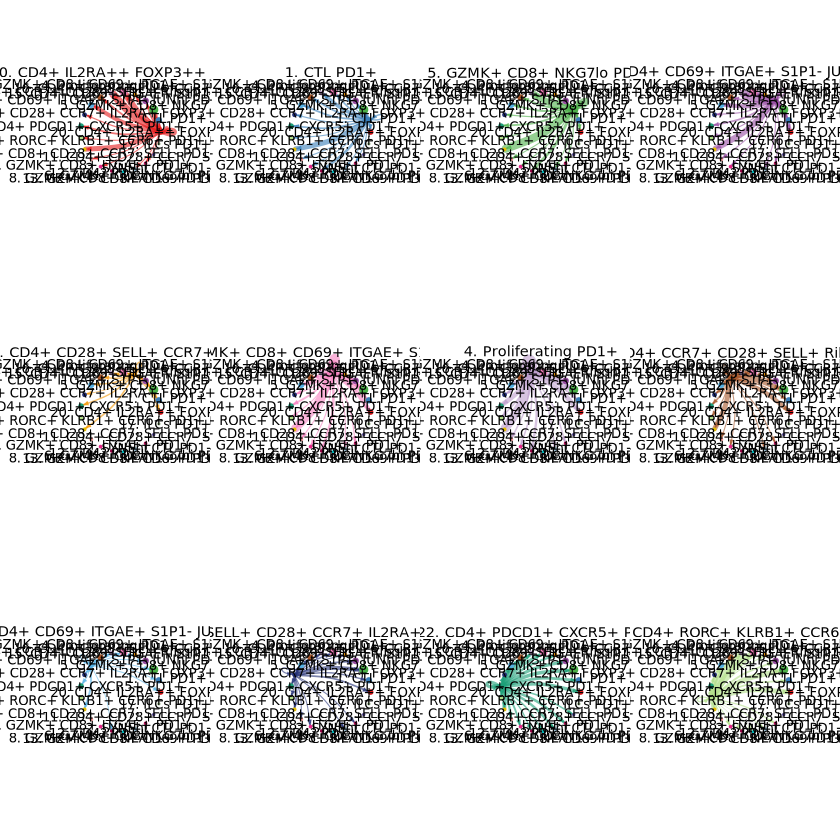

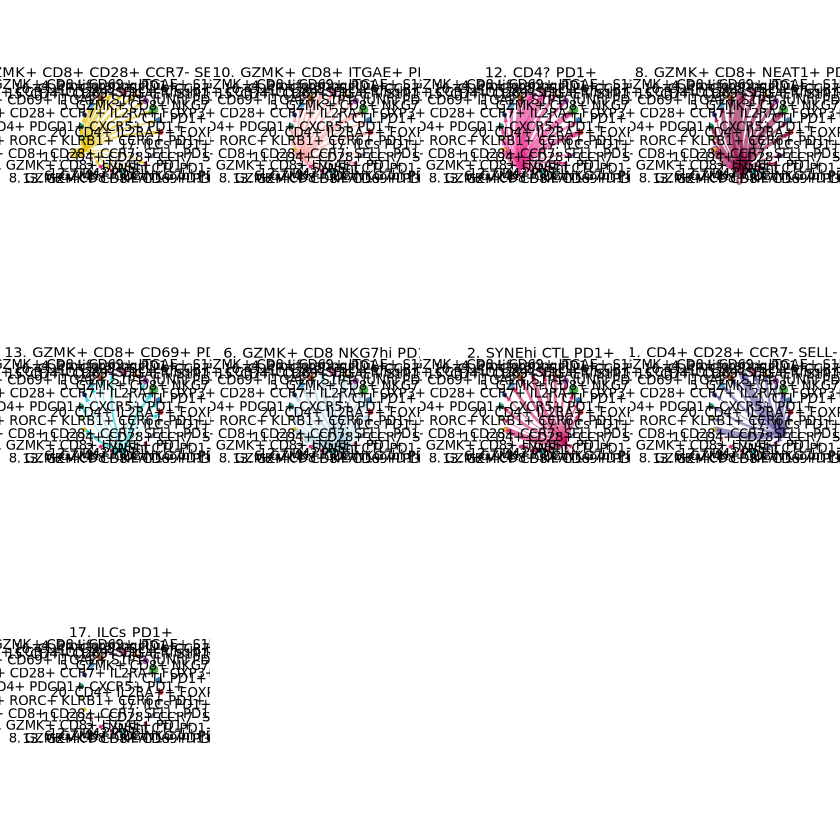

In [41]:
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

In [62]:
pathway <- unique(df.net$pathway_name)
pathway

[1] "CCL"      "CXCL"     "MIF"      "IL16"     "TNF"      "LIGHT"   
 [7] "SPP1"     "PARs"     "GALECTIN" "BTLA"     "CypA"

Processing pathway: CCL



Processing pathway: CXCL

Processing pathway: MIF



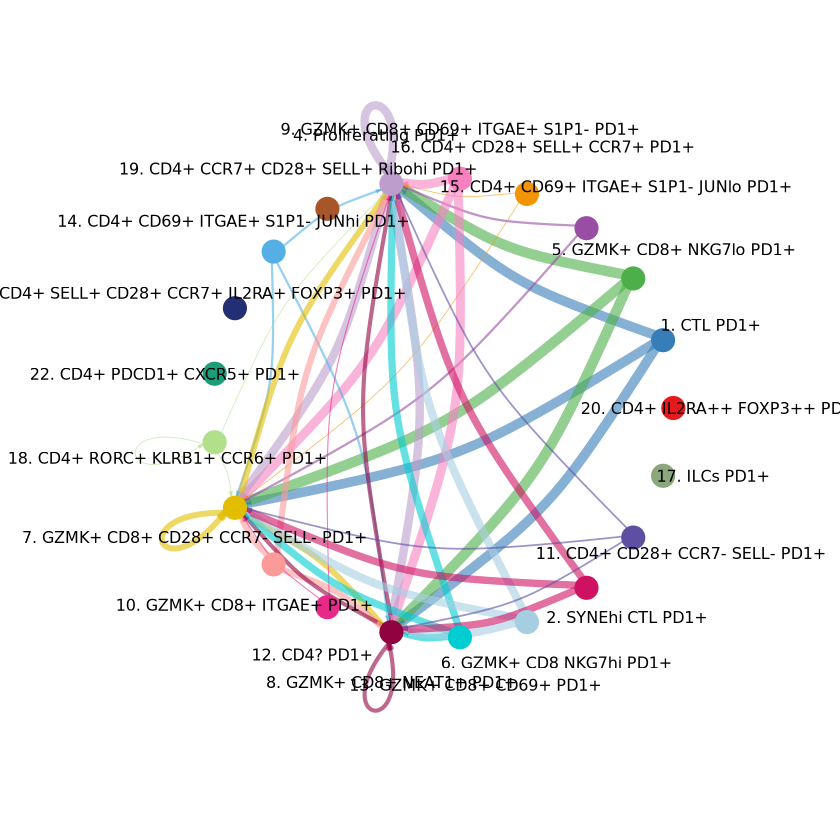

Processing pathway: IL16



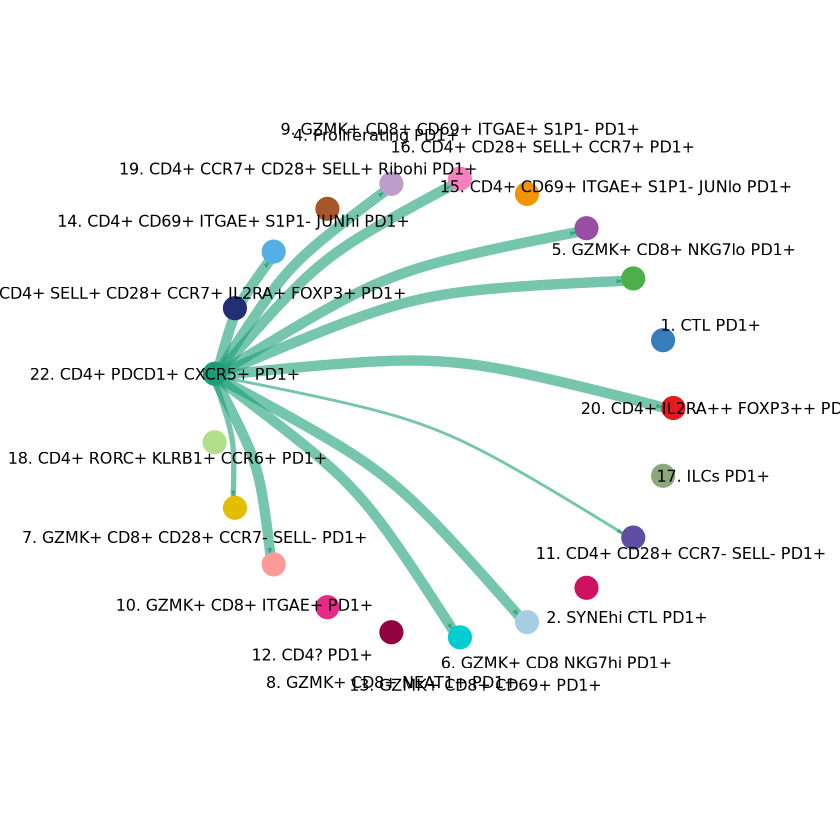

Processing pathway: TNF



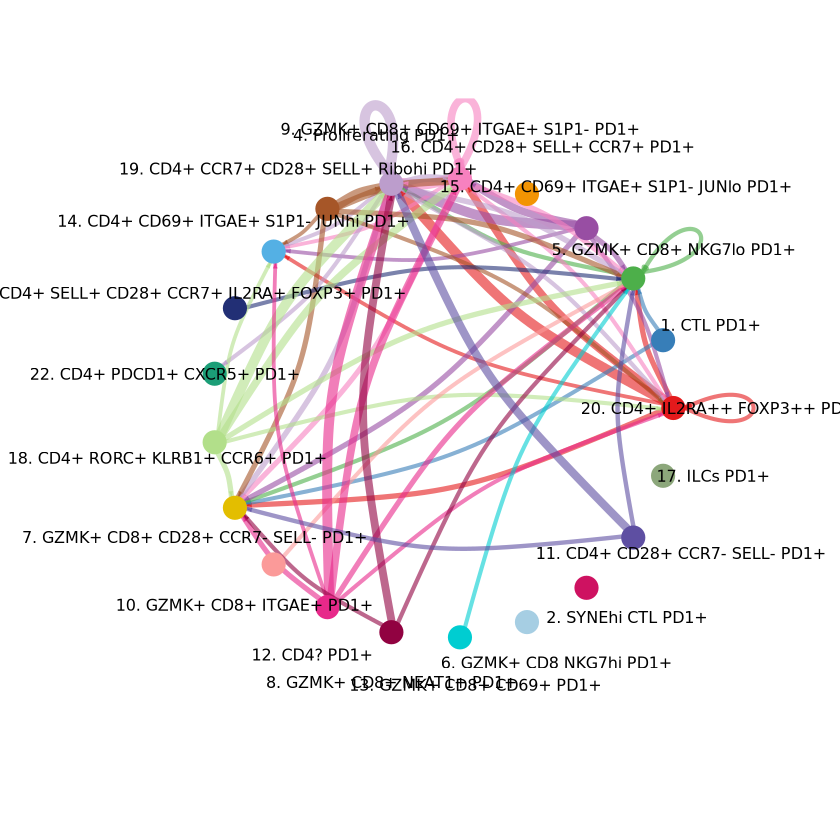

Processing pathway: LIGHT



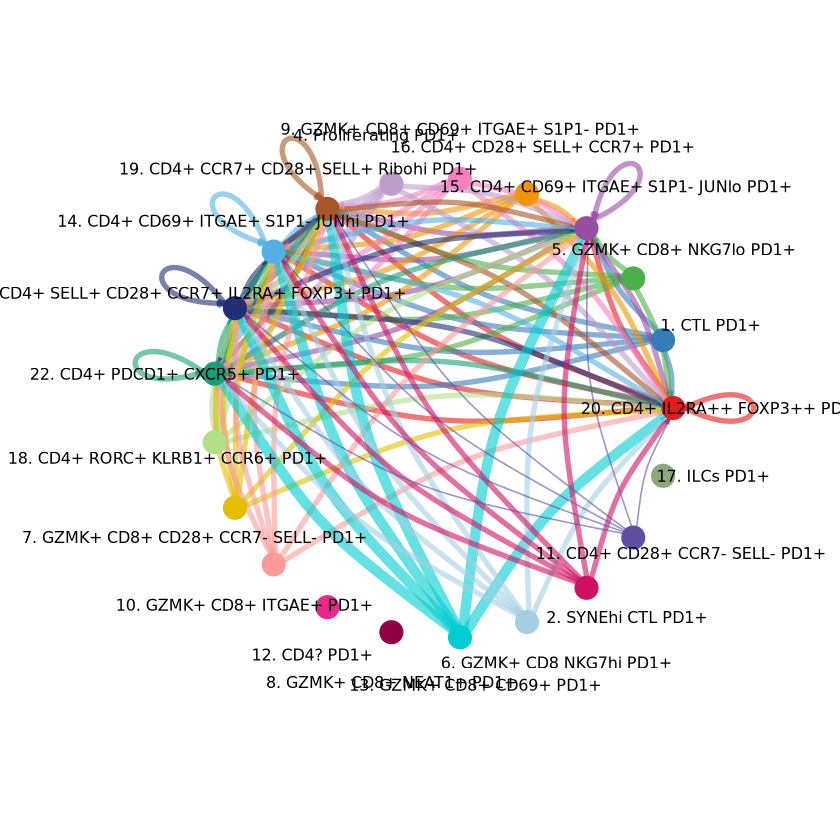

Processing pathway: SPP1



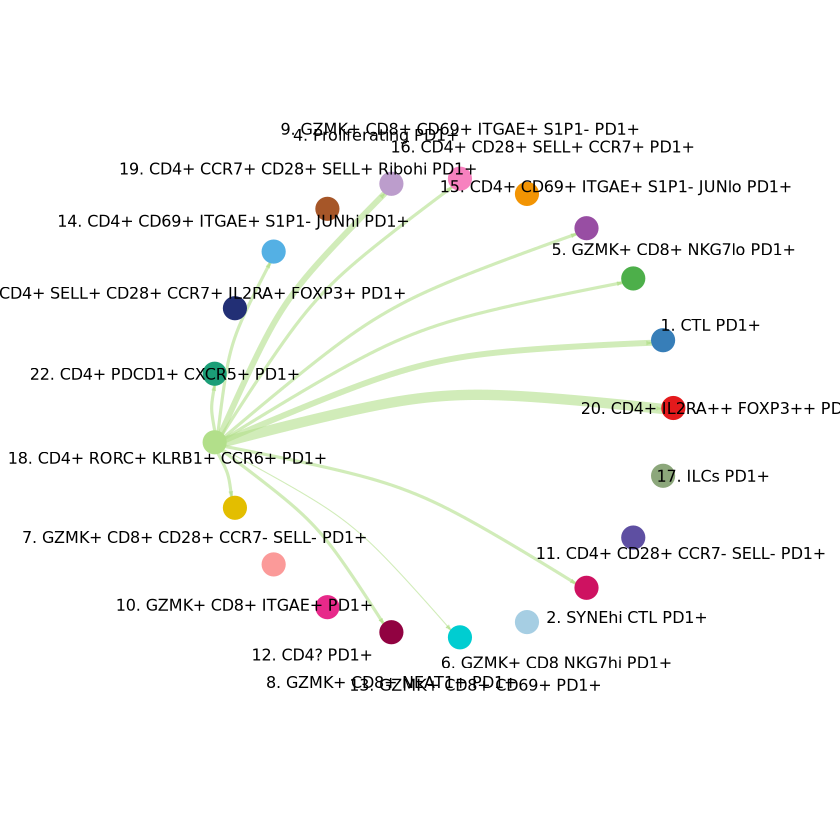

Processing pathway: PARs



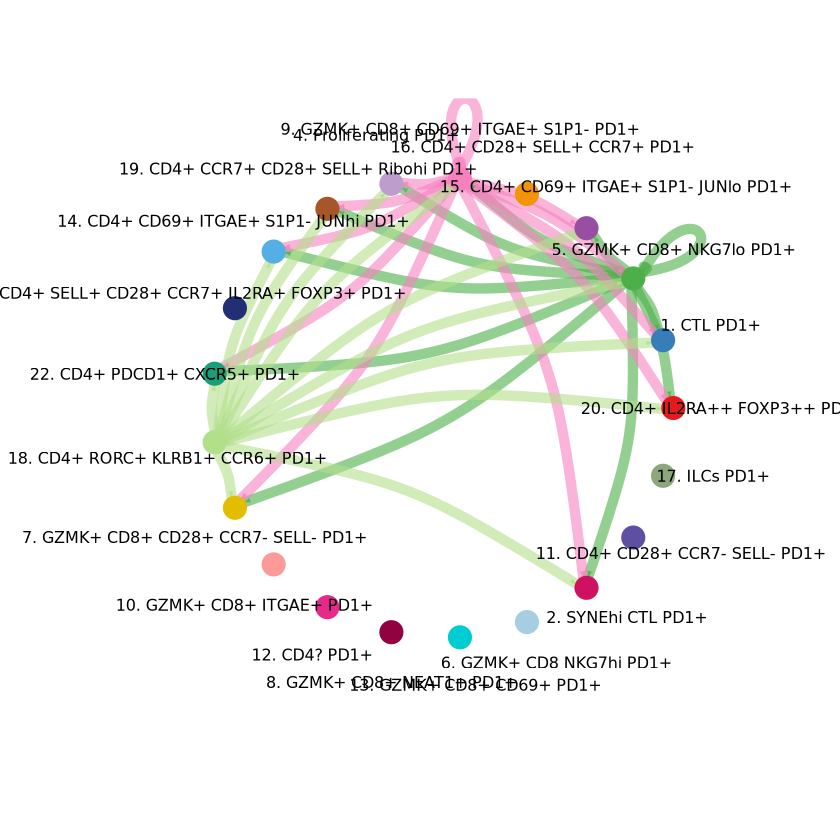

Processing pathway: GALECTIN



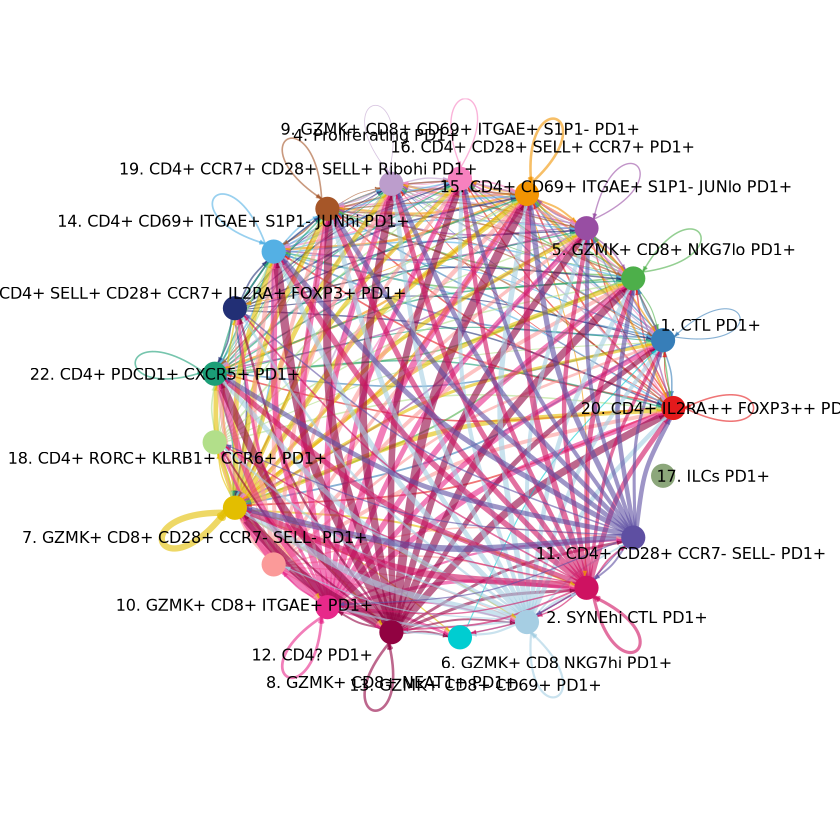

Processing pathway: BTLA



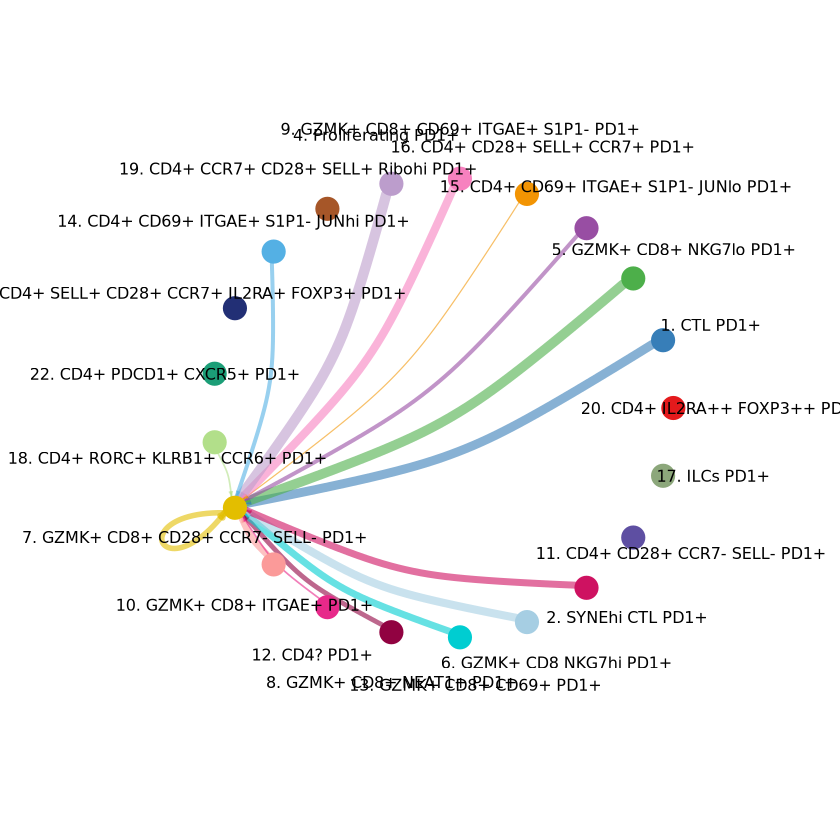

Processing pathway: CypA



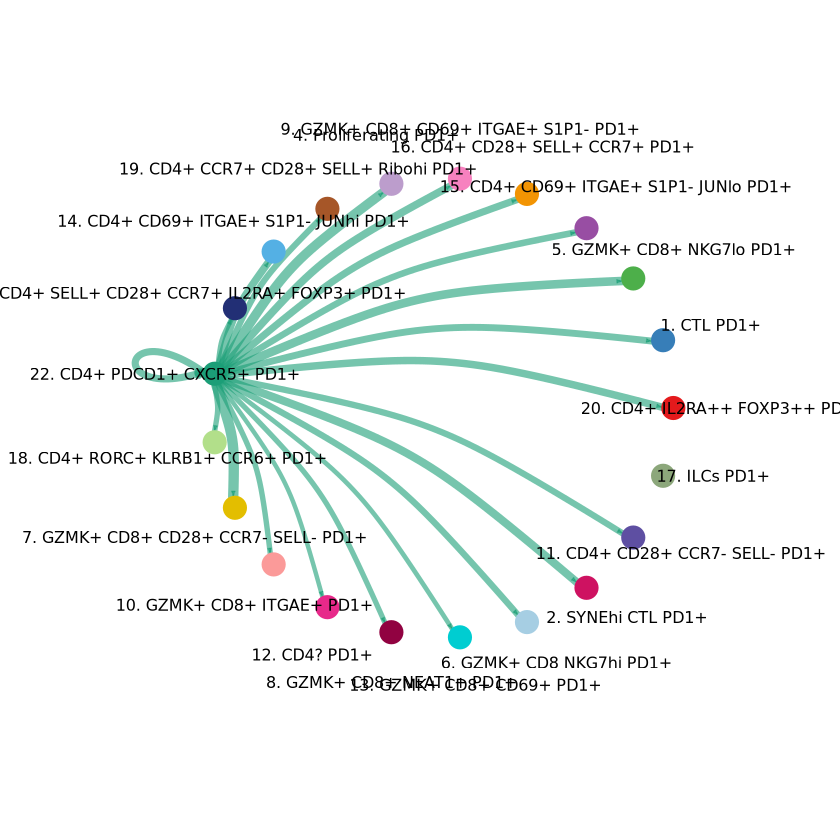

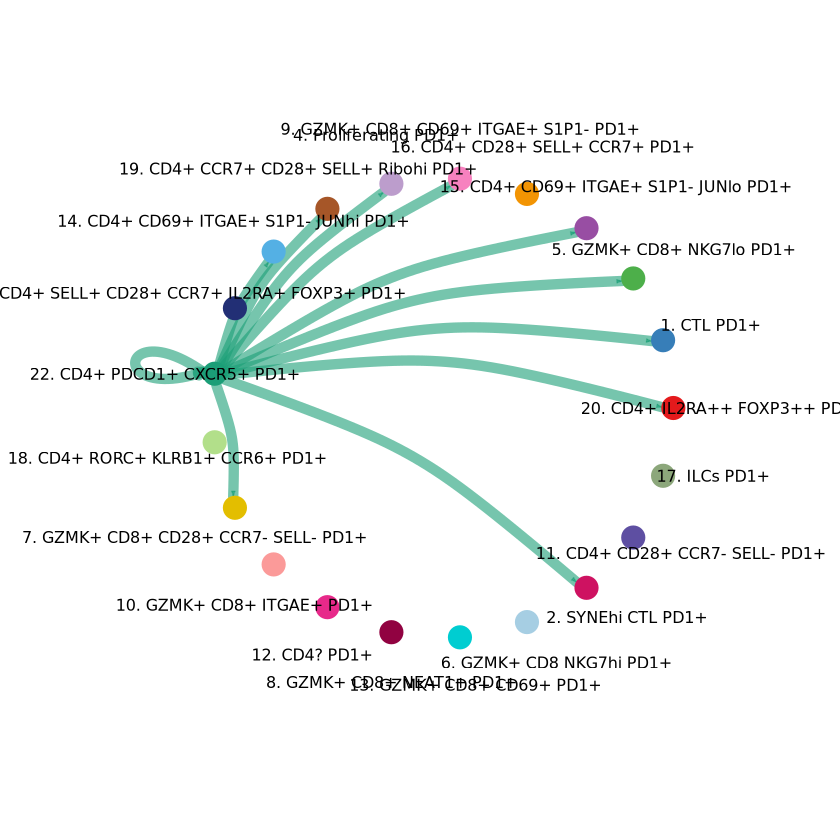

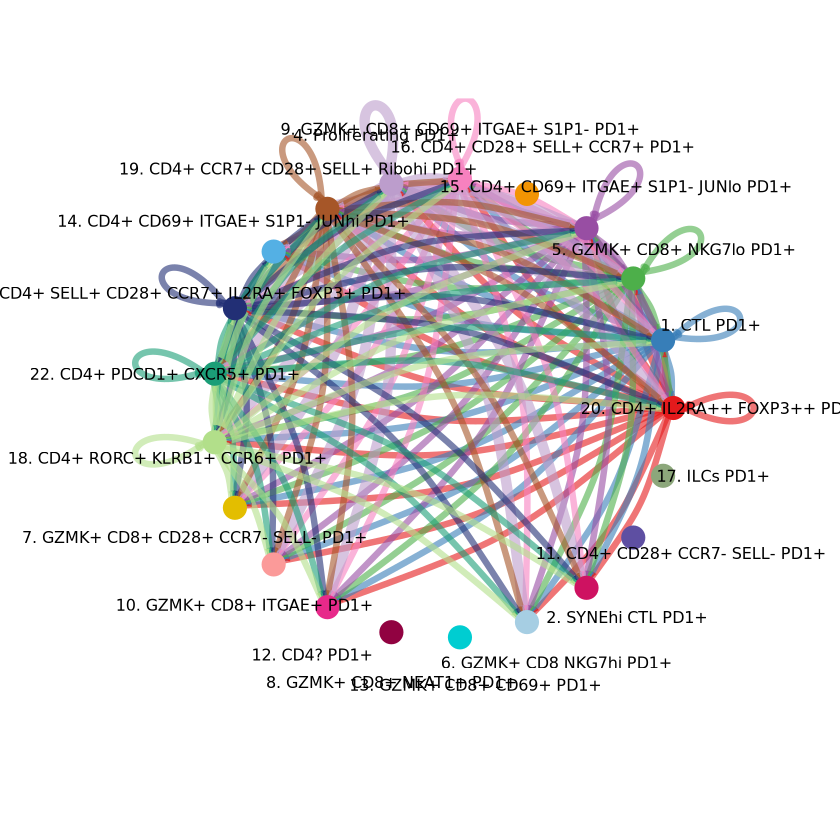

In [63]:
for (p in pathway) {
  message(paste("Processing pathway:", p))
  
  # Generate the plot
  tryCatch({
    plot <- netVisual_aggregate(cellchat, signaling = p, vertex.receiver = vertex.receiver)
    print(plot)  # Ensure that each plot is printed
  }, error = function(e) {
    message(paste("Error processing pathway:", p, "Error:", e$message))
  })
}